# BME-1312 Lab-2: Segmentation using U-Net

In [8]:
######################## WRITE YOUR ANSWER BELOW ########################
STUDENT_NAME = 'Example'
STUDENT_NUMBER = '1234567890'
#########################################################################

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup environments
You are required to install the following packages.
- jupyter
- scikit-image
- numPy
- pytorch torchvision
- matplotlib
- tqdm
- scikit-learn

In [1]:
# necessary packages for this homework, you are free to import more.
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
import os
import random
from PIL import Image
import sklearn

# packages of this lab
from bme1312 import lab2 as lab

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Importing successful')

Importing successful


## Part 1: Dataset preparation


**Dataset for training**
1. Initialize the variables of the dataset.
2. Obtain the pair of the original image and GT. 

In [8]:
from torchvision import transforms as T
from torchvision.transforms import functional as F

class ImageFolder(data.Dataset):
    def __init__(self, root, mode='train', augmentation_prob=0.4):
        assert mode in {'train'}
        """Initializes image paths and preprocessing module."""
        self.root = root

        # GT : Ground Truth
        self.GT_dir = os.path.join(root,'GT/')
        self.image_names = os.listdir(self.GT_dir)
        self.len = len(self.image_names)
        self.GT_paths = [os.path.join(self.GT_dir,self.image_names[i]) for i in range(self.len)]
        
        #Generate the paths of input images.
        ######################## WRITE YOUR ANSWER BELOW ########################
        self.image_dir = os.path.join(root,'Img/')
        self.image_paths = [os.path.join(self.image_dir ,self.image_names[i]) for i in range(self.len)]
        #########################################################################
        self.mode = mode
        self.RotationDegree = [0, 90, 180, 270]
        self.augmentation_prob = augmentation_prob
        print("image count in {} path :{}".format(self.mode, self.len))

    def __getitem__(self, index):
        """Reads an image from a file and preprocesses it and returns."""
        image_path = self.image_paths[index]
        filename = self.image_names[index]
        GT_path = self.GT_paths[index]

        image = Image.open(image_path)
        seg_gt = Image.open(GT_path)

        aspect_ratio = image.size[1] / image.size[0]

        Transform = []

        ResizeRange = random.randint(300, 320)
        Transform.append(T.Resize((int(ResizeRange * aspect_ratio), ResizeRange)))
        p_transform = random.random()

        if (self.mode == 'train') and p_transform <= self.augmentation_prob:
            
            RotationDegree = random.randint(0, 3)
            RotationDegree = self.RotationDegree[RotationDegree]
            if (RotationDegree == 90) or (RotationDegree == 270):
                aspect_ratio = 1 / aspect_ratio
            
            Transform.append(T.RandomRotation((RotationDegree, RotationDegree)))
            
            #use randint and T.RandomRotation to rotate the image by (-10,10) degrees.
            ######################## WRITE YOUR ANSWER BELOW ########################
            RotationRange = random.randint(-10, 10)
            Transform.append(T.RandomRotation((RotationRange, RotationRange)))
            #########################################################################
            
            CropRange = random.randint(250, 270)
            Transform.append(T.CenterCrop((int(CropRange * aspect_ratio), CropRange)))
            Transform = T.Compose(Transform)
            
            image = Transform(image)
            
            #Be careful: when you do geometric transformation on the original image,you need to do
            #the same transform on the gt, to keep the consistency.
            ######################## WRITE YOUR ANSWER BELOW ########################
            seg_gt = Transform(seg_gt)
            #########################################################################
            

            ShiftRange_left = random.randint(0, 20)
            ShiftRange_upper = random.randint(0, 20)
            ShiftRange_right = image.size[0] - random.randint(0, 20)
            ShiftRange_lower = image.size[1] - random.randint(0, 20)
            image = image.crop(box=(ShiftRange_left, ShiftRange_upper, ShiftRange_right, ShiftRange_lower))
            seg_gt = seg_gt.crop(box=(ShiftRange_left, ShiftRange_upper, ShiftRange_right, ShiftRange_lower))

            if random.random() < 0.5:
                image = F.hflip(image)
                seg_gt = F.hflip(seg_gt)

            if random.random() < 0.5:
                image = F.vflip(image)
                seg_gt = F.vflip(seg_gt)
            
            
            #use T.ColorJitter to do color transform here. You can't change the color
            #of gt! Set brightness=0.2, contrast=0.2, hue=0.02.
            ######################## WRITE YOUR ANSWER BELOW ########################
            Transform = T.ColorJitter(brightness=0.2, contrast=0.2, hue=0.02)
            #########################################################################
            image = Transform(image)

            Transform = []

        Transform.append(T.Resize((int(256 * aspect_ratio) - int(256 * aspect_ratio) % 16, 256)))
        Transform.append(T.ToTensor())
        Transform = T.Compose(Transform)

        image = Transform(image)
        seg_gt = Transform(seg_gt)

        Norm_ = T.Normalize((0.5), (0.5))
        image = Norm_(image)

        return image, seg_gt

    def __len__(self):
        """Returns the total number of font files."""
        return self.len
    

    
train_folder = ImageFolder(root = 'dataset/ACDC-2D-onelabel/train/' , mode = 'train')




image count in train path :1394


In [7]:
train_folder.datas[1][0].shape


torch.Size([1, 256, 256])

In [14]:
class Test_ImageFolder(data.Dataset):
    def __init__(self, root, mode='val'):
        """Initializes image paths and preprocessing module."""
        assert mode in {'val','test'}
        self.root = root

        
        self.GT_dir = os.path.join(root,'GT/')
        self.image_names = os.listdir(self.GT_dir)
        self.len = len(self.image_names)
        self.GT_paths = [os.path.join(self.GT_dir,self.image_names[i]) for i in range(self.len)]
        
        
        self.image_dir = os.path.join(root,'Img/')
        self.image_paths = [os.path.join(self.image_dir ,self.image_names[i]) for i in range(self.len)]
        
        self.mode = mode
        # self.RotationDegree = [0, 90, 180, 270]
        # self.augmentation_prob = augmentation_prob
        print("image count in {} path :{}".format(self.mode, len(self.image_paths)))

    def __getitem__(self, index):
        """Reads an image from a file and preprocesses it and returns."""
        image_path = self.image_paths[index]
        # # filename = self.image_names[index]
        GT_path = self.GT_paths[index]

        image = Image.open(image_path)
        seg_gt = Image.open(GT_path)

        # image = Image.open(image_path)

        # aspect_ratio = image.size[1] / image.size[0]

        Transform = []
        # ResizeRange = random.randint(300, 320)
        # Transform.append(T.Resize((int(ResizeRange * aspect_ratio), ResizeRange)))

        # Transform.append(T.Resize((int(256 * aspect_ratio) - int(256 * aspect_ratio) % 16, 256)))
        Transform.append(T.ToTensor())
        Transform = T.Compose(Transform)

        image = Transform(image)
        
        seg_gt = Transform(seg_gt)
        Norm_ = T.Normalize((0.5), (0.5))
        image = Norm_(image)
        return image,seg_gt

    def __len__(self):
        """Returns the total number of font files."""
        return self.len

#Get val_folder and test_folder using Test_ImageFolder.
######################## WRITE YOUR ANSWER BELOW ########################
val_folder = Test_ImageFolder(root = 'dataset/ACDC-2D-onelabel/val/' , mode = 'val')
test_folder = Test_ImageFolder(root = 'dataset/ACDC-2D-onelabel/test/' , mode = 'test')
#########################################################################


image count in val path :404
image count in test path :204


In [15]:

def get_loader(image_root_path, batch_size, num_workers=0, mode='train', augmentation_prob=0.4):
    """Builds and returns Dataloader."""
    if mode=='test' or mode == 'val':
        dataset = Test_ImageFolder(root=image_root_path, mode=mode)
    else:
        dataset = ImageFolder(root=image_root_path, mode=mode, augmentation_prob=augmentation_prob)

    data_loader = data.DataLoader(dataset=dataset,
                                batch_size=batch_size,
                                shuffle=True if mode == 'train' else False,
                                num_workers=num_workers)

    return data_loader
train_loader = get_loader(image_root_path='dataset/ACDC-2D-onelabel/train/', batch_size=10, mode='train')
#Get val_loader and test_loader using get_loader.
######################## WRITE YOUR ANSWER BELOW ########################
val_loader = get_loader(image_root_path='dataset/ACDC-2D-onelabel/val/', batch_size=10, mode='val')
test_loader = get_loader(image_root_path='dataset/ACDC-2D-onelabel/test/', batch_size=10, mode='test')
#########################################################################




image count in train path :1394
image count in val path :404
image count in test path :204


torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])


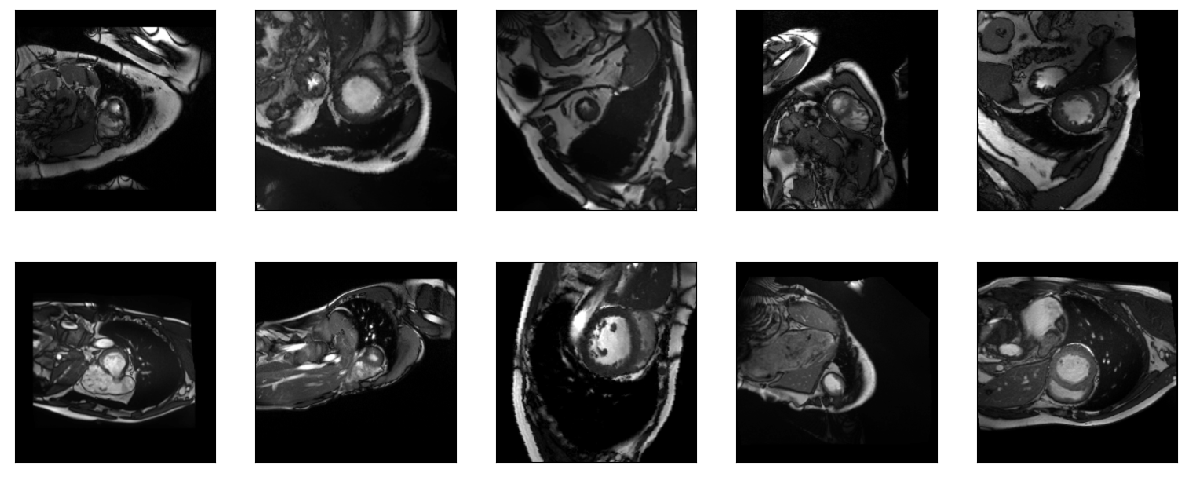

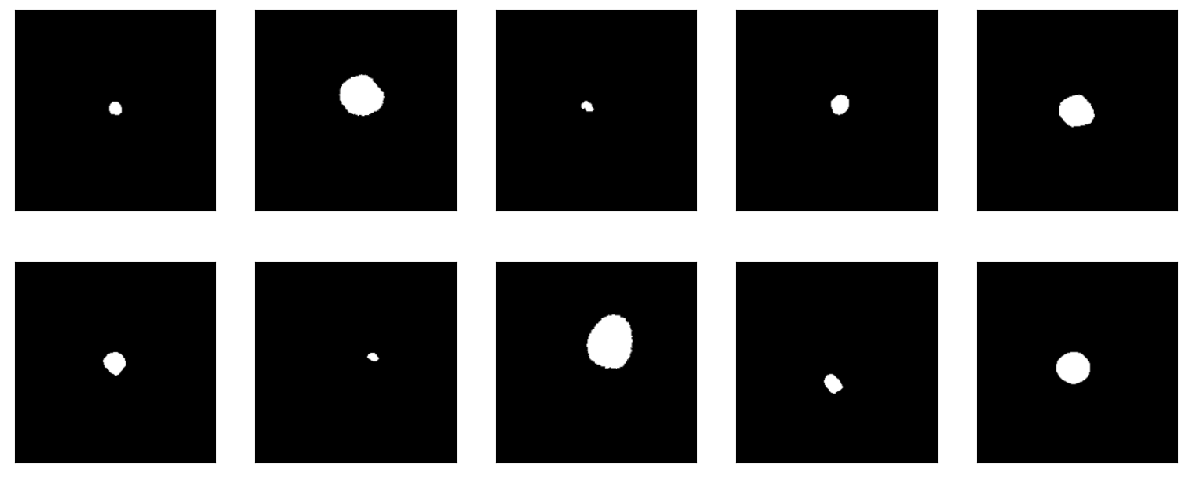

In [16]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(train_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)
lab.imsshow(image[:,0,  :, :])
lab.imsshow(seg_gt[:,0, :, :])

**Range of values**
1. Images' intensities are normalized to $[-1, 1]$
2. Segmentation ground truths are defined between $[0, 1]$

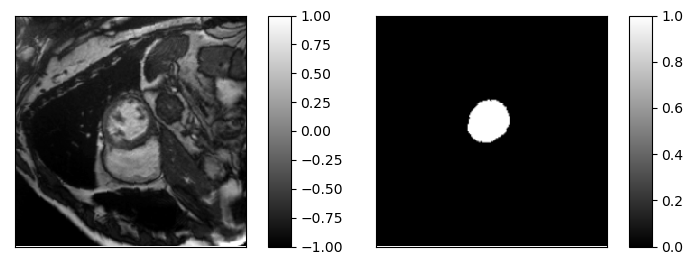

In [12]:
lab.imsshow([image[5, 0, :, :], seg_gt[5, 0, :, :]], is_colorbar=True)

torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 256, 256])


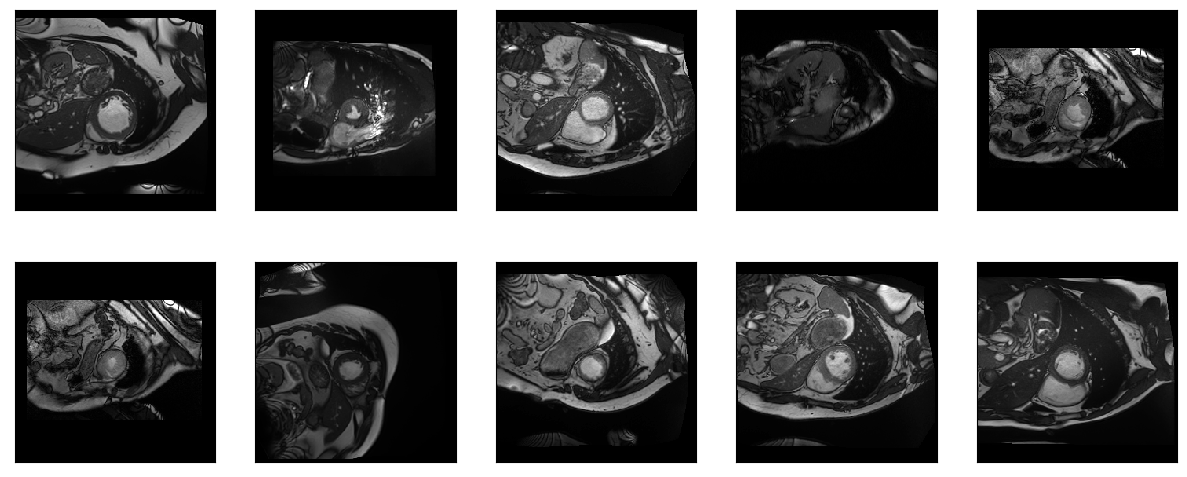

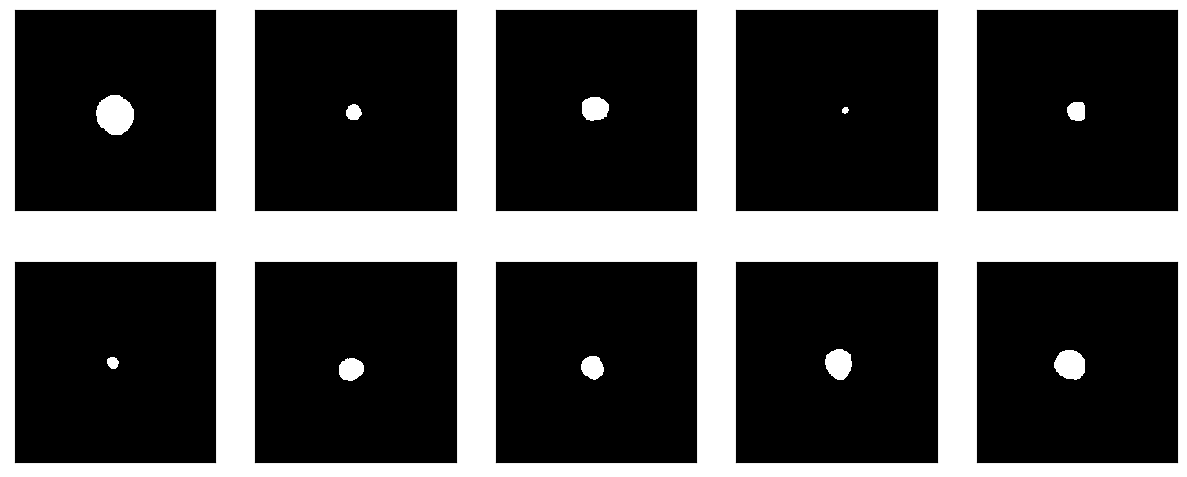

In [17]:
batch = lab.fetch_batch_sample(val_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)
lab.imsshow(image[:, 0, :, :])
lab.imsshow(seg_gt[:, 0, :, :])

## Part 2: Evaluation Metrics for Segmentation Tasks

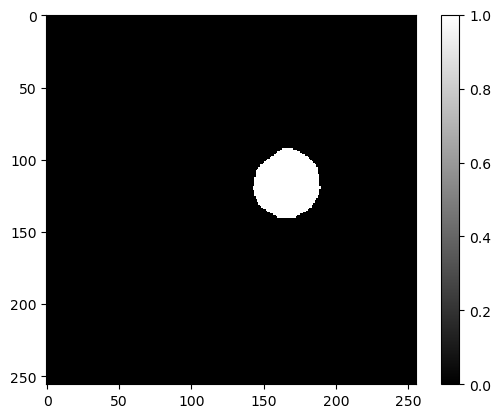

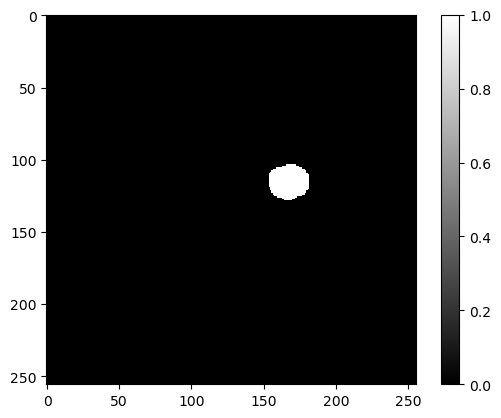

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


In [18]:
mask1 = Image.open('assets/mask1.png')
mask1 = np.array (mask1)>0
lab.imgshow(mask1)

mask2 = Image.open('assets/mask2.png')
mask2 = np.array(mask2)>0
lab.imgshow(mask2)

mask1 = torch.tensor(mask1).unsqueeze(0).unsqueeze(0)
mask2 = torch.tensor(mask2).unsqueeze(0).unsqueeze(0)
print(mask1.shape)
print(mask2.shape)

In [19]:
import bme1312.evaluation as evaluation

def accuracy(SR, GT, threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)
    corr = torch.sum(SR == GT)
    tensor_size = SR.size(0) * SR.size(1) * SR.size(2) * SR.size(3)
    acc = float(corr) / float(tensor_size)

    return acc

your_acc = accuracy(mask1,mask2)
std_acc = evaluation.get_accuracy(mask1,mask2)
print("your_acc:",your_acc)
print("std_acc:",std_acc)
assert(abs(your_acc-std_acc)<1e-6) 

your_acc: 0.9825897216796875
std_acc: 0.9825897216796875


In [20]:


def sensitivity(SR, GT, threshold=0.5):
    # Sensitivity == Recall
    SR = SR > threshold
    GT = GT == torch.max(GT)

    # TP : True Positive
    # FN : False Negative
    TP = ((SR == 1) & (GT == 1))
    #calculate FN
    ######################## WRITE YOUR ANSWER BELOW ########################
    FN = ((SR == 0) & (GT == 1))
    #########################################################################
    

    # print("torch.sum(TP)",torch.sum(TP))
    # print("torch.sum(TP + FN)",torch.sum(TP + FN))

    SE = float(torch.sum(TP)) / (float(torch.sum(TP + FN)) + 1e-6)

    return SE

your_sen = sensitivity(mask1,mask2)
std_sen = evaluation.get_sensitivity(mask1,mask2)
print("your_sen:",your_sen)
print("std_sen:",std_sen)
assert(abs(your_sen-std_sen)<1e-6)

your_sen: 0.9999999982046679
std_sen: 1.0


In [21]:

def specificity(SR, GT, threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)

    # TN : True Negative
    # FP : False Positive
    
    #calculate TN and FP
    ######################## WRITE YOUR ANSWER BELOW ########################
    TN = ((SR == 0) & (GT == 0))
    FP = ((SR == 1) & (GT == 0))
    #########################################################################
    

    SP = float(torch.sum(TN)) / (float(torch.sum(TN + FP)) + 1e-6)

    # print("------------------specificity---------------")
    # print("TN:",torch.sum(TN))
    # print("FP:",torch.sum(FP))
    # print("SP:",SP)
    return SP


your_spe = specificity(mask1,mask2)
std_spe = evaluation.get_specificity(mask1,mask2)
print("your_spe:",your_spe)
print("std_spe:",std_spe)
assert(abs(your_spe-std_spe)<1e-6)

your_spe: 0.9824404807555912
std_spe: 0.9824404807707106


In [22]:
def precision(SR, GT, threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)

    # TP : True Positive
    # FP : False Positive
    TP = ((SR == 1) & (GT == 1))
    FP = ((SR == 1) & (GT == 0))
    
    #calculate precision. use eps=1e-6 to avoid zero division.
    ######################## WRITE YOUR ANSWER BELOW ########################
    PC = float(torch.sum(TP)) / (float(torch.sum(TP + FP)) + 1e-6)
    #########################################################################
    

    # print("------------------precision---------------")
    # print("TP:", torch.sum(TP))
    # print("FP:", torch.sum(FP))
    # print("PC:", PC)
    return PC

your_prec = precision(mask1,mask2)
std_prec = evaluation.get_precision(mask1,mask2)
print("your_prec:",your_prec)
print("std_prec:",std_prec)
assert(abs(your_prec-std_prec)<1e-6)

your_prec: 0.328032979783255
std_prec: 0.3280329799764429


In [23]:
def F1(SR, GT, threshold=0.5):
    
    SE = sensitivity(SR, GT, threshold=threshold)
    PC = precision(SR, GT, threshold=threshold)
    
    #Calculate F1. use eps=1e-6 to avoid zero division.
    ######################## WRITE YOUR ANSWER BELOW ########################
    F1 = 2 * SE * PC / (SE + PC + 1e-6)
    #########################################################################
    

    return F1

your_F1 = F1(mask1,mask2)
std_F1 = evaluation.get_F1(mask1,mask2)
print("your_F1:",your_F1)
print("std_F1:",std_F1)
assert(abs(your_F1-std_F1)<1e-6)

your_F1: 0.49401293134280033
std_F1: 0.4940133037694013


In [24]:
def JS(SR, GT, threshold=0.5):
    # JS : Jaccard similarity
    SR = SR > threshold
    GT = GT == torch.max(GT)

    Inter = torch.sum(((SR == 1) & (GT == 1)))
    
    #Calculate Union between SR and GT.
    ######################## WRITE YOUR ANSWER BELOW ########################
    Union = torch.sum((SR + GT) >= 1)
    #########################################################################
    JS = float(Inter) / (float(Union) + 1e-6)

    return JS

your_JS = JS(mask1,mask2)
std_JS = evaluation.get_JS(mask1,mask2)
print("your_JS:",your_JS)
print("std_JS:",std_JS)
assert(abs(your_JS-std_JS)<1e-6)


your_JS: 0.328032979783255
std_JS: 0.3280329799764429


In [25]:
def DC(SR, GT, threshold=0.5):
    # DC : Dice Coefficient
    SR = SR > threshold
    GT = GT == torch.max(GT)


    Inter = torch.sum(((SR==1) & (GT==1)))
    #calculate DC.
    ######################## WRITE YOUR ANSWER BELOW ########################
    DC = float(2 * Inter) / (float(torch.sum(SR) + torch.sum(GT)) + 1e-6)
    #########################################################################
    

    return DC

your_DC = DC(mask1,mask2)
std_DC = evaluation.get_DC(mask1,mask2)
print("your_DC:",your_DC)
print("std_DC:",std_DC)
assert(abs(your_DC-std_DC)<1e-6)

your_DC: 0.49401330355032674
std_DC: 0.4940133037694013


## Part 3: U-Net

Original            |  Simplification
:-------------------------:|:-------------------------:
![](./assets/unet-validconv.png)  |  ![](./assets/unet-simplification.png)

### 3.1 MultiConv
<center>
    <img src="./assets/DoubleConv.png" width="80%">
</center>

In [26]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        #use nn.Sequential(),BatchNorm2d,ReLU. Use padding to keep the size of image.
        ######################## WRITE YOUR ANSWER BELOW ########################
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        #########################################################################

    def forward(self, x):
        """
        x: [B, C_in, H, W]
        out: [B, C_out, H, W]
        """
        out = self.layers(x)
        return out


net = DoubleConv(in_channels=2, out_channels=64)
x = torch.randn(5, 2, 160, 160)
out = net(x)
assert (5, 64, 160, 160) == out.shape

### 3.2 Down/Up Block

<center>
    <img src="./assets/Down.png" width="80%">
</center>

In [27]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        #use nn.Sequential,nn.MaxPool2d and DoubleConv defined by you.
        ######################## WRITE YOUR ANSWER BELOW ########################
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        #########################################################################

    def forward(self, x):        
        ######################## WRITE YOUR ANSWER BELOW ########################
        return self.maxpool_conv(x)
        #########################################################################


net = Down(in_channels=64, out_channels=128)
x = torch.randn(5, 64, 160, 160)
out = net(x)
assert (5, 128, 80, 80) == out.shape

<center>
    <img src="./assets/Up.png" width="80%">
</center>

In [28]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()        
        
        #use nn.ConvTranspose2d for upsampling.
        ######################## WRITE YOUR ANSWER BELOW ########################
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        #########################################################################
        self.conv = DoubleConv(in_channels, out_channels)
        

    def forward(self, x1, x2):        
        
        
        x1 = self.up(x1)
        H1, W1 = x1.shape[2:]
        H2, W2 = x2.shape[2:]
        
        # print('before padding:', x1.shape)
        
        #use F.pad to change the shape of x1.
        ######################## WRITE YOUR ANSWER BELOW ########################
        x1 = F.pad(x1, [
            (W2-W1) // 2, # left
            (W2-W1) // 2, # right
            (H2-H1) // 2, # top
            (H2-H1) // 2  # bottom
            ])
        #########################################################################
        # print('after padding: ',x1.shape)

        x = torch.cat([x2, x1], dim=1)
        out = self.conv(x)
        
        return out

net = Up(in_channels=128, out_channels=64)
x = torch.randn(5, 128, 80, 80)
x_res = torch.randn(5, 64, 160, 160)
out = net(x, x_res)
assert (5, 64, 160, 160) == out.shape


net = Up(in_channels=128, out_channels=64)
x = torch.randn(5, 128, 196, 196)
x_res = torch.randn(5, 64, 568, 568)
out = net(x, x_res)
assert (5, 64, 568, 568) == out.shape

### 3.3 Compose together

<center>
    <img src="./assets/unet-simplification.png">
</center>

Trick for manipulating dimension of channel: 1x1 convolution as projection
<center>
    <img src="./assets/1x1conv_projection.png" width="60%">
</center>

In [29]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, C_base=64):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        #Use class defined by you. Be careful about params here.
        ######################## WRITE YOUR ANSWER BELOW ########################
        self.in_conv = DoubleConv(n_channels, C_base)

        self.down1 = Down(C_base, 2 * C_base)
        self.down2 = Down(2 * C_base, 4 * C_base)
        self.down3 = Down(4 * C_base, 8 * C_base)
        self.down4 = Down(8 * C_base, 16 * C_base)
        self.up1 = Up(16 * C_base, 8 * C_base)
        self.up2 = Up(8 * C_base, 4 * C_base)
        self.up3 = Up(4 * C_base, 2 * C_base)
        self.up4 = Up(2 * C_base, C_base)
        #########################################################################
        self.out_projection = nn.Conv2d(C_base, n_classes, kernel_size=1)
        

    def forward(self, x):
        """
        :param x: [B, n_channels, H, W]
        :return [B, n_classes, H, W]
        """ 
        ######################## WRITE YOUR ANSWER BELOW ########################
        x1 = self.in_conv(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        #########################################################################
        pred = self.out_projection(x)        
        
        return pred


net = UNet(n_channels=1, n_classes=1)
x = torch.randn(5, 1, 256, 256)
out = net(x)
assert (5, 1, 256, 256) == out.shape

## Part 4: Binary cross-entropy

Step 1: normalize the predictions (output from network)
<center>
    <img src="./assets/sigmoid.png", width="80%">
</center>

Step 2: use binary cross entropy to measure the distance
1. Each pixel's loss value can be defined as:
$$
 l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]
$$
2. Using `mean` reduction to compute averaged loss
$$
\ell(x, y) = L = \frac{1}{N} \sum(\{l_1,\dots,l_N\})
$$

In [30]:
class MyBinaryCrossEntropy(object):
    def __init__(self):
        self.sigmoid = nn.Sigmoid()
        self.bce = nn.BCELoss(reduction='mean')
    
    def __call__(self, pred_seg, seg_gt):
        """
        :param pred_seg: [B, C=1, H, W]
        :param seg_gt: [B, C=1, H, W]
        """        
        #get the probability by sigmoid. Use BCEloss.
        ######################## WRITE YOUR ANSWER BELOW ########################
        pred_seg_probs = self.sigmoid(pred_seg)
        loss = self.bce(pred_seg_probs, seg_gt)
        #########################################################################
        return loss


seg_pred = torch.randn(2, 1, 256, 256)
seg_gt = torch.randn(2, 1, 256, 256)
criteron = MyBinaryCrossEntropy()
loss = criteron(seg_pred, seg_gt)


## Part 5: Train you segmentation network

### Construct your solver

Training trick: let learning rate slowly decay usually results in better performance.
<center>
    <img src="./assets/scheduler_motivation.png", width="90%">
</center>
<center>
    <img src="./assets/lr_scheduler.png", width="60%">
</center>

In [31]:
net = UNet(n_channels=1, n_classes=1, C_base=32)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

solver = lab.Solver(
    model = net,
    optimizer = optimizer,
    criterion = MyBinaryCrossEntropy(),
    lr_scheduler=lr_scheduler
)

image count in train path :1394
image count in val path :404
image count in test path :204


  0%|          | 0/1394 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/404 [00:00<?, ?img/s]

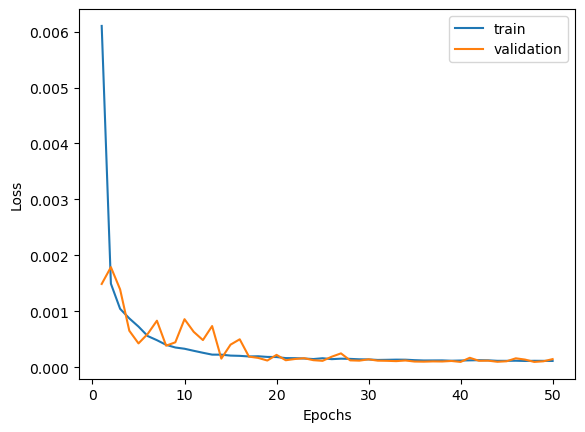

In [32]:
train_loader = get_loader(image_root_path='dataset/ACDC-2D-onelabel/train/', batch_size=32, mode='train')
val_loader = get_loader(image_root_path='dataset/ACDC-2D-onelabel/val/', batch_size=32, mode='val')
test_loader = get_loader(image_root_path='dataset/ACDC-2D-onelabel/test/', batch_size=32, mode='test')

solver.train(
    epochs=50, 
    data_loader=train_loader,
    val_loader=val_loader
)

In [33]:
solver.validate(
    data_loader=val_loader
)

[Validation]:   0%|          | 0/404 [00:00<?, ?img/s]

============================== Measurements ==============================
[avg_Sensitivity] 0.8530755116033405
[avg_Specifity] 0.999844842961447
[avg_Precision] 0.981426484868703
[avg_F1Score] 0.9123177689229276
[avg_JaccardSimilarity] 0.8398046572705413
[avg_DiceCoefficient] 0.9123177689229276


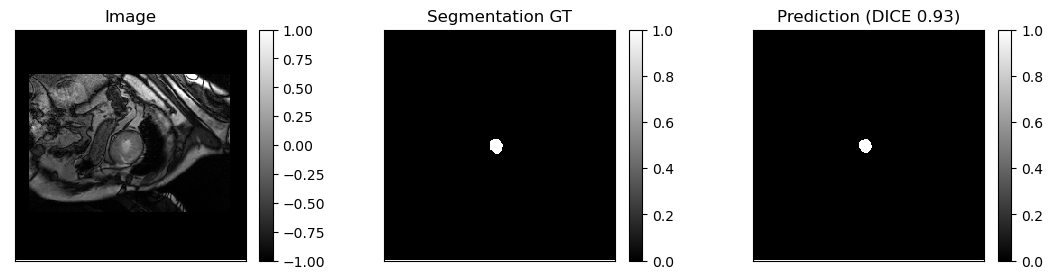

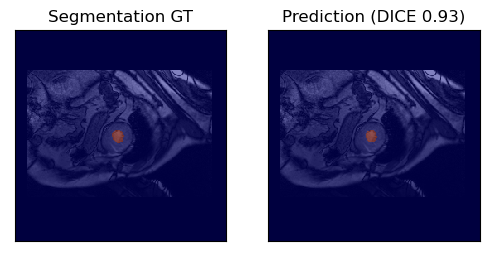

In [34]:
solver.visualize(
    data_loader=val_loader,
    idx=5 
)

In [35]:
solver.validate(
    data_loader=test_loader
)

[Validation]:   0%|          | 0/204 [00:00<?, ?img/s]

============================== Measurements ==============================
[avg_Sensitivity] 0.8075538328013292
[avg_Specifity] 0.9998719388582296
[avg_Precision] 0.9796234365424846
[avg_F1Score] 0.8837896863570627
[avg_JaccardSimilarity] 0.7941934544206816
[avg_DiceCoefficient] 0.8837896863570627


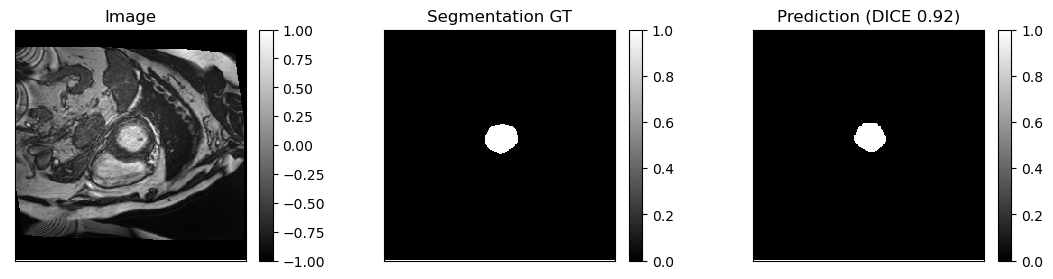

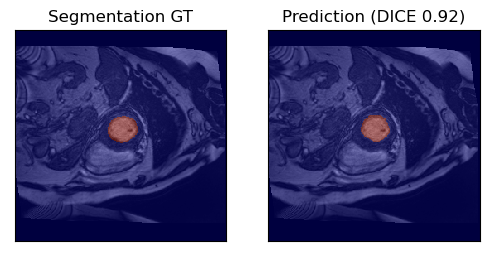

In [36]:
solver.visualize(
    data_loader=test_loader,
    idx=10  
)